In [1]:
import pandas as pd
import numpy as np 
import datetime
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


Date      datetime64[ns]
Period             int64
Value            float64
dtype: object


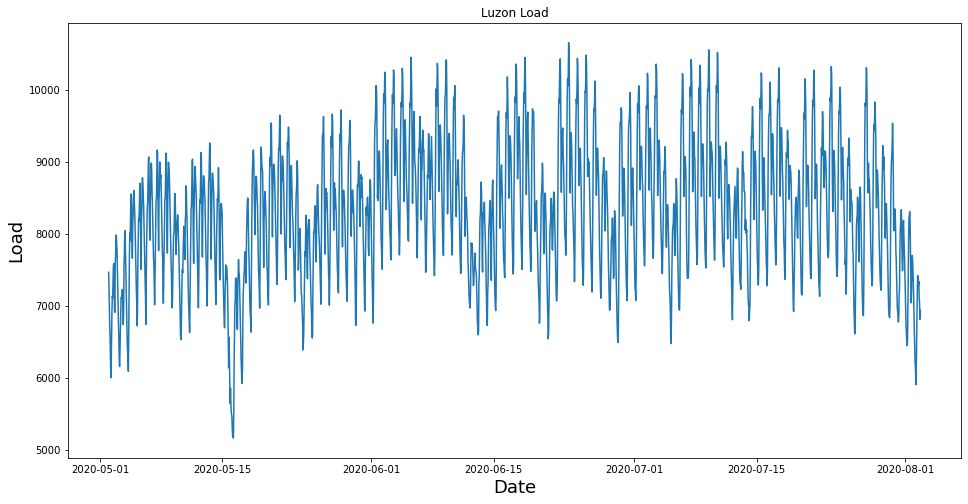

,Date,Period,Value
Date,,,
2020-05-02 00:00:00,2020-05-02 00:00:00,1,7466.0
2020-05-02 01:00:00,2020-05-02 01:00:00,2,7238.1
2020-05-02 02:00:00,2020-05-02 02:00:00,3,6934.5
2020-05-02 03:00:00,2020-05-02 03:00:00,4,6706.9
2020-05-02 04:00:00,2020-05-02 04:00:00,5,6555.9
...,...,...,...
2020-08-02 13:00:00,2020-08-02 13:00:00,14,7340.2
2020-08-02 14:00:00,2020-08-02 14:00:00,15,7115.1
2020-08-02 15:00:00,2020-08-02 15:00:00,16,7032.0


In [2]:
# load data + set time
data = pd.read_csv('4-Volume.csv')

# convert the data type of the column to DateTime
data['Date']= pd.to_datetime(data['Date']) 
print(data.dtypes)
data['Date'] = pd.to_datetime(data.Date, format='%Y-%m-%d')
data.index = data['Date']

plt.figure(figsize=(16, 8))
plt.title('Luzon Load')
plt.plot(data['Value'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load', fontsize=18)
plt.show()

data

In [3]:
# extract data for each period + specific date
data_split = data#.loc[data['Period'] == 18]
# define input sequence
data_seq_train = data_split.loc[data_split["Date"] <= "2020-07-27"]
data_seq_test = data_split.loc[data_split["Date"] > "2020-07-27"]
data_seq_test

,Date,Period,Value
Date,,,
2020-07-27 01:00:00,2020-07-27 01:00:00,2,7380.3
2020-07-27 02:00:00,2020-07-27 02:00:00,3,7159.0
2020-07-27 03:00:00,2020-07-27 03:00:00,4,6995.6
2020-07-27 04:00:00,2020-07-27 04:00:00,5,6887.5
2020-07-27 05:00:00,2020-07-27 05:00:00,6,6863.7
...,...,...,...
2020-08-02 13:00:00,2020-08-02 13:00:00,14,7340.2
2020-08-02 14:00:00,2020-08-02 14:00:00,15,7115.1
2020-08-02 15:00:00,2020-08-02 15:00:00,16,7032.0


In [4]:
# define input sequence
data_seq_train = list(data_seq_train['Value'])
data_seq_test = list(data_seq_test['Value'])

data_seq_train

[7466.0,
 7238.1,
 6934.5,
 6706.9,
 6555.9,
 6315.5,
 6004.0,
 6188.9,
 6540.6,
 6905.9,
 7133.6,
 7108.4,
 7303.1,
 7552.4,
 7584.8,
 7369.7,
 6946.6,
 6912.1,
 7608.4,
 7682.5,
 7945.9,
 7983.4,
 7870.2,
 7753.2,
 7524.2,
 7242.0,
 6969.1,
 6735.9,
 6520.9,
 6263.6,
 6158.9,
 6360.0,
 6624.3,
 6866.2,
 7113.5,
 7123.9,
 7112.0,
 7227.2,
 7214.7,
 6981.4,
 6741.7,
 6908.0,
 7540.9,
 7682.2,
 8017.9,
 8043.3,
 7774.9,
 7587.1,
 7242.2,
 6897.4,
 6664.1,
 6470.3,
 6363.4,
 6265.8,
 6094.8,
 6674.0,
 7328.2,
 7728.3,
 8007.7,
 7902.8,
 8262.6,
 8547.3,
 8550.9,
 8319.5,
 7922.6,
 7661.7,
 8117.4,
 8278.3,
 8489.6,
 8601.4,
 8504.6,
 8360.5,
 8200.5,
 7936.1,
 7621.5,
 7382.4,
 7214.3,
 7056.8,
 6726.2,
 6915.5,
 7528.7,
 7910.9,
 8212.9,
 8172.9,
 8345.7,
 8591.7,
 8700.8,
 8353.1,
 7790.2,
 7507.5,
 8162.6,
 8364.7,
 8758.6,
 8776.5,
 8675.8,
 8522.9,
 8361.5,
 8074.2,
 7835.4,
 7606.6,
 7416.5,
 7124.0,
 6744.1,
 7273.2,
 7856.2,
 8102.7,
 8365.0,
 8434.5,
 8691.2,
 9017.9,
 9064.0,
 

In [5]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [6]:
# choose a number of time steps
n_steps = 24
# split into samples
X_train, y_train = split_sequence(data_seq_train, n_steps)
X_test, y_test = split_sequence(data_seq_test, n_steps)

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

print(X_train.shape[0], X_train.shape[1])
# y_test

2041 24


In [7]:
# define model
model = Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_percentage_error'])
# fit model
model.fit(X_train, y_train, epochs=200, verbose=1, batch_size = 24)

Epoch 1/200
 264/2041 [==>...........................] - ETA: 6s - loss: 20747796.8636 - mean_absolute_percentage_error: 43.8560

KeyboardInterrupt: 

In [ ]:
# demonstrate prediction
y_test_hat = model.predict(X_test, verbose=0)
y_test = list(y_test)
for i in range(len(y_test_hat)):
    print(y_test_hat[i]-y_test[i])

In [ ]:
# calcute MAPE Error on test data

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPE=mean_absolute_percentage_error(y_test, y_test_hat)
MAPE

In [ ]:
# plot the y_test and y_test_hat (prediction on test data)

plt.figure(figsize=(16, 8))
plt.title('Univariate Stacked LSTM - Load Prediction from 2020-07-27 - 2020-08-02 with MAPE='+ str(MAPE))
plt.plot(y_test, 'o--', alpha=1)
plt.plot(y_test_hat, 'o--', alpha=0.9)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load', fontsize=18)
plt.legend(['true volume', 'predicted volume'], loc='upper right')

plt.show()


# Visuliza Model + RMSE + Weights

In [ ]:
from keras.utils.vis_utils import plot_model
# pip install pydot
# conda install python-graphviz

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

RMSE=measure_rmse(y_test, y_test_hat)
RMSE

In [ ]:
for layer in model.layers:
    weights = layer.get_weights() 
    
weights